In [1]:
"""Гипотеза 1: датасет корректно загружается, структура колонок и базовые статистики понятны."""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("muted")

PATH = "TransFiles_3rzk6/ci_data.csv"

# Читаем RefNo как строку, чтобы не терять формат 3.00E+11
df_raw = pd.read_csv(PATH, dtype={"RefNo": str})

print("Первые 5 строк сырого датафрейма:")
display(df_raw.head())
print("\nИнформация о колонках:")
df_raw.info()

Первые 5 строк сырого датафрейма:


,Date,Category,RefNo,Date.1,Withdrawal,Deposit,Balance
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/1/2023,Rent,3.00E+11,1/1/2023,3950.0,0.0,1837.23
2,3/1/2023,Misc,3.00E+11,3/1/2023,105.0,0.0,1732.23
3,3/1/2023,Misc,3.37E+11,3/1/2023,0.0,55.0,1787.23
4,3/1/2023,Food,3.00E+11,3/1/2023,56.0,0.0,1731.23



Информация о колонках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1469 non-null   object 
 1   Category    1469 non-null   object 
 2   RefNo       1469 non-null   object 
 3   Date.1      1469 non-null   object 
 4   Withdrawal  1469 non-null   float64
 5   Deposit     1469 non-null   float64
 6   Balance     1469 non-null   float64
dtypes: float64(3), object(4)
memory usage: 80.5+ KB


In [2]:
"""Гипотеза 2: во входных данных есть полностью пустые строки, их нужно удалить перед анализом."""

df_eda = df_raw.copy()

before = len(df_eda)
df_eda = df_eda.dropna(how="all")
print(f"До Обрезания {before} и после {len(df_eda)}")

До Обрезания 1470 и после 1469


In [3]:
"""Гипотеза 3: два столбца с датами можно объединить в один корректный столбец даты транзакции."""

primary = pd.to_datetime(df_eda["Date"], dayfirst=True, errors="coerce")
backup = pd.to_datetime(df_eda.get("Date.1", df_eda["Date"]), dayfirst=True, errors="coerce")

df_eda["Date"] = primary.fillna(backup)
df_eda = df_eda.dropna(subset=["Date"]).copy()

# сортируем по дате
df_eda = df_eda.sort_values("Date").reset_index(drop=True)

print("Диапазон дат после объединения:")
print(df_eda["Date"].min(), "→", df_eda["Date"].max())

Диапазон дат после объединения:
2023-01-01 00:00:00 → 2024-01-01 00:00:00


In [4]:
"""Гипотеза 4: числовые колонки ('Withdrawal', 'Deposit', 'Balance') могут содержать строки, их нужно привести к числу."""

for col in ["Withdrawal", "Deposit", "Balance"]:
    df_eda[col] = pd.to_numeric(df_eda[col], errors="coerce")

print("Числовые колонки после преобразования:")
display(df_eda[["Withdrawal", "Deposit", "Balance"]].describe())

Числовые колонки после преобразования:


,Withdrawal,Deposit,Balance
count,571.000000,571.000000,571.000000
mean,282.375779,148.094308,2968.383730
std,1197.336644,1008.467317,2575.634116
min,0.000000,0.000000,0.150000
25%,20.000000,0.000000,1000.020000
50%,48.000000,0.000000,2112.820000
75%,125.000000,0.000000,4302.105000
max,15048.000000,15000.000000,15291.970000


Распределение NetAmount и AbsAmount:


,NetAmount,AbsAmount
count,571.000000,571.000000
mean,-134.281471,430.470088
std,1591.981341,1538.453167
min,-15048.000000,1.000000
25%,-125.000000,33.000000
50%,-48.000000,60.000000
75%,-20.000000,184.500000
max,15000.000000,15048.000000


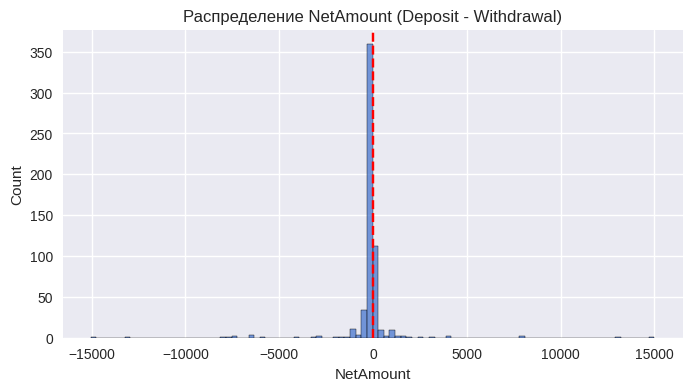

In [5]:
"""Гипотеза 5: удобно ввести признаки NetAmount (чистый поток) и AbsAmount (модуль суммы операции)."""

# Чистый поток: приход минус расход
df_eda["NetAmount"] = df_eda["Deposit"].fillna(0) - df_eda["Withdrawal"].fillna(0)
# Модуль движения денег
df_eda["AbsAmount"] = df_eda["Withdrawal"].fillna(0) + df_eda["Deposit"].fillna(0)

print("Распределение NetAmount и AbsAmount:")
display(df_eda[["NetAmount", "AbsAmount"]].describe())

plt.figure(figsize=(8, 4))
sns.histplot(df_eda["NetAmount"], bins=100)
plt.axvline(0, color="red", linestyle="--")
plt.title("Распределение NetAmount (Deposit - Withdrawal)")
plt.show()

In [6]:
"""Гипотеза 6: календарные признаки (год, месяц, день, день недели, неделя) помогут искать временные паттерны."""

df_eda["Year"] = df_eda["Date"].dt.year
df_eda["Month"] = df_eda["Date"].dt.to_period("M")
df_eda["Day"] = df_eda["Date"].dt.day
df_eda["Weekday"] = df_eda["Date"].dt.weekday
df_eda["Week"] = df_eda["Date"].dt.isocalendar().week.astype(int)

print("Пример календарных признаков:")
display(df_eda[["Date", "Year", "Month", "Day", "Weekday", "Week"]].head())

Пример календарных признаков:


,Date,Year,Month,Day,Weekday,Week
0,2023-01-01,2023,2023-01,1,6,52
1,2023-01-03,2023,2023-01,3,1,1
2,2023-01-03,2023,2023-01,3,1,1
3,2023-01-03,2023,2023-01,3,1,1
4,2023-01-03,2023,2023-01,3,1,1


Число транзакций по категориям:


Category
Food         357
Misc         196
Shopping       9
Rent           7
Transport      2
Name: count, dtype: int64

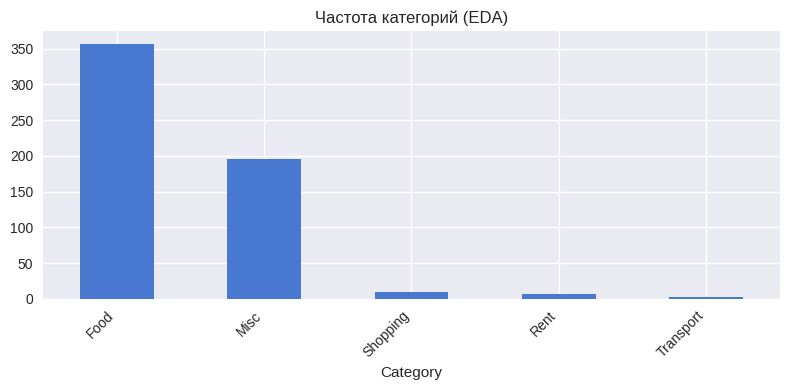

In [7]:
"""Гипотеза 7: распределение категорий транзакций неравномерно, есть несколько доминирующих классов."""

cat_counts_eda = df_eda["Category"].value_counts()
print("Число транзакций по категориям:")
display(cat_counts_eda)

plt.figure(figsize=(8, 4))
cat_counts_eda.plot(kind="bar")
plt.title("Частота категорий (EDA)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Суммарный AbsAmount по категориям:


Category
Shopping       2141.00
Transport      4780.00
Food          19178.16
Rent          43804.00
Misc         175895.26
Name: AbsAmount, dtype: float64

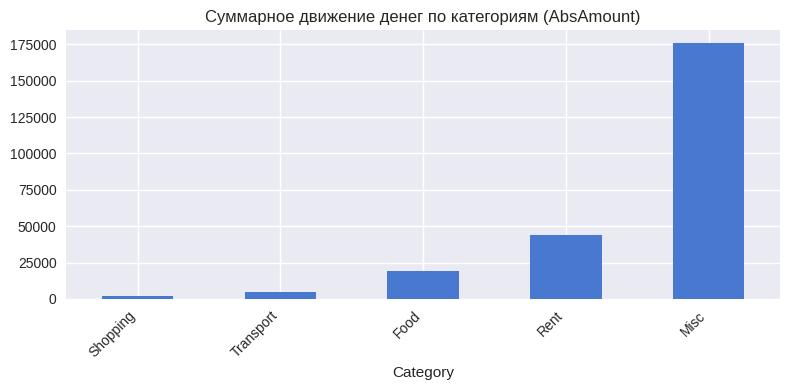

In [8]:
"""Гипотеза 8: по абсолютной сумме движения денег разные категории дают разный вклад в бюджет."""

cat_sum_eda = df_eda.groupby("Category")["AbsAmount"].sum().sort_values()
print("Суммарный AbsAmount по категориям:")
display(cat_sum_eda)

plt.figure(figsize=(8, 4))
cat_sum_eda.plot(kind="bar")
plt.title("Суммарное движение денег по категориям (AbsAmount)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

,Month,FlowType,NetAmount
0,2023-01,Inflow,1410.00
1,2023-01,Outflow,-6568.50
2,2023-02,Inflow,1626.00
3,2023-02,Outflow,-12171.43
4,2023-03,Inflow,641.00


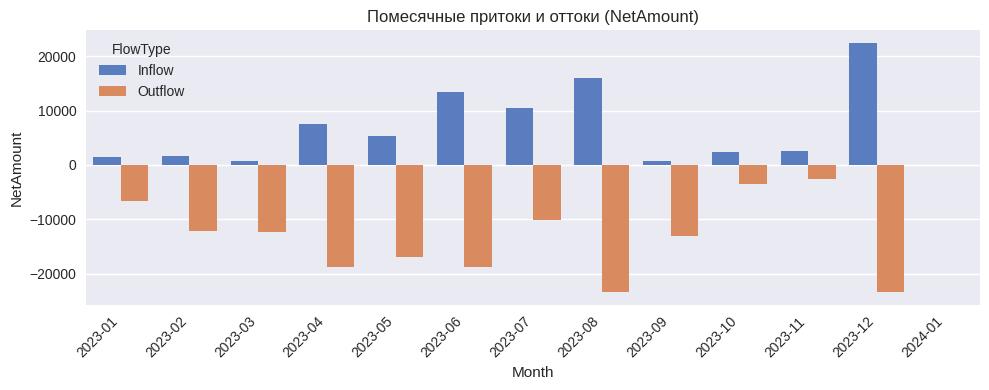

In [9]:
"""Гипотеза 9: помесячные притоки и оттоки (NetAmount) показывают периоды с наибольшими изменениями баланса."""

monthly_flow_eda = (
    df_eda
    .assign(FlowType=np.where(df_eda["NetAmount"] >= 0, "Inflow", "Outflow"))
    .groupby(["Month", "FlowType"])["NetAmount"]
    .sum()
    .reset_index()
)

display(monthly_flow_eda.head())

plt.figure(figsize=(10, 4))
sns.barplot(data=monthly_flow_eda, x="Month", y="NetAmount", hue="FlowType")
plt.title("Помесячные притоки и оттоки (NetAmount)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Арендные транзакции (EDA):


,Date,Withdrawal,Deposit,NetAmount,Balance
0,2023-01-01,3950.0,0.0,-3950.0,1837.23
40,2023-02-02,5776.0,0.0,-5776.0,5750.97
111,2023-03-03,6490.0,0.0,-6490.0,4265.89
163,2023-04-01,6356.0,0.0,-6356.0,6696.94
228,2023-05-01,6463.0,0.0,-6463.0,5965.52
414,2023-08-02,7459.0,0.0,-7459.0,1781.62
445,2023-09-01,7310.0,0.0,-7310.0,5036.86


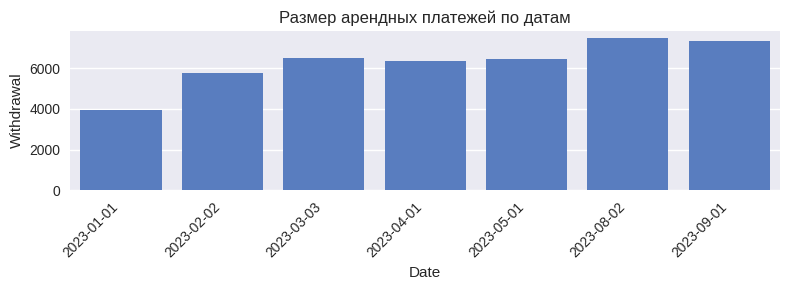

In [10]:
"""Гипотеза 10: арендные платежи ('Rent') являются крупными и редкими расходами по сравнению с другими."""

rent_eda = df_eda[df_eda["Category"] == "Rent"].copy()
print("Арендные транзакции (EDA):")
display(rent_eda[["Date", "Withdrawal", "Deposit", "NetAmount", "Balance"]])

if not rent_eda.empty:
    plt.figure(figsize=(8, 3))
    sns.barplot(data=rent_eda, x="Date", y="Withdrawal")
    plt.title("Размер арендных платежей по датам")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

Дни месяца для аренды:


,Date,Day,Withdrawal
0,2023-01-01,1,3950.0
40,2023-02-02,2,5776.0
111,2023-03-03,3,6490.0
163,2023-04-01,1,6356.0
228,2023-05-01,1,6463.0
414,2023-08-02,2,7459.0
445,2023-09-01,1,7310.0


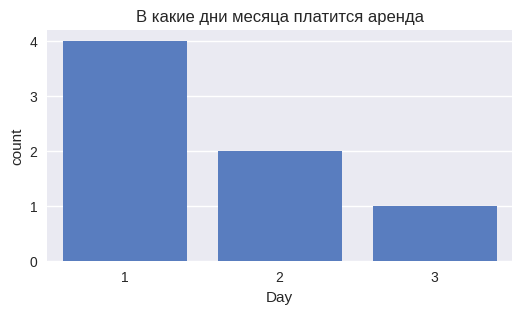

In [11]:
"""Гипотеза 11: аренда платится в первые дни месяца (1–3 числа)."""

if not rent_eda.empty:
    rent_eda["Day"] = rent_eda["Date"].dt.day
    print("Дни месяца для аренды:")
    display(rent_eda[["Date", "Day", "Withdrawal"]])

    plt.figure(figsize=(6, 3))
    sns.countplot(data=rent_eda, x="Day")
    plt.title("В какие дни месяца платится аренда")
    plt.show()

,Month,TotalExp,RentExp,RentShare,Month_str
0,2023-01,6568.50,3950.0,0.601355,2023-01
1,2023-02,12171.43,5776.0,0.474554,2023-02
2,2023-03,12231.63,6490.0,0.530592,2023-03
3,2023-04,18679.43,6356.0,0.340267,2023-04
4,2023-05,16984.16,6463.0,0.380531,2023-05
5,2023-08,23380.00,7459.0,0.319033,2023-08
6,2023-09,13018.29,7310.0,0.561518,2023-09


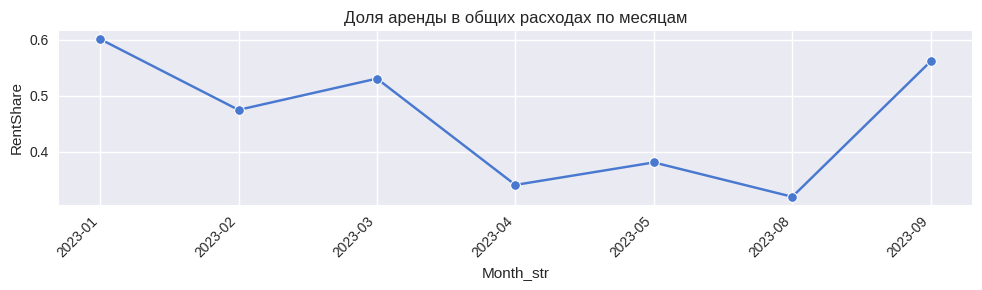

In [12]:
"""Гипотеза 12: доля аренды в общих расходах по месяцам заметна и может меняться со временем."""

expenses_eda = df_eda[df_eda["Withdrawal"] > 0].copy()
rent_exp_eda = rent_eda[rent_eda["Withdrawal"] > 0].copy()

total_by_month_eda = expenses_eda.groupby("Month")["Withdrawal"].sum()
rent_by_month_eda = rent_exp_eda.groupby("Month")["Withdrawal"].sum()

share_eda = (
    pd.concat(
        [total_by_month_eda.rename("TotalExp"), rent_by_month_eda.rename("RentExp")],
        axis=1,
    )
    .dropna()
    .reset_index()
)
share_eda["RentShare"] = share_eda["RentExp"] / share_eda["TotalExp"]

# seaborn не любит PeriodIndex по оси X, делаем человеко-читаемую строку для месяца
share_eda["Month_str"] = share_eda["Month"].astype(str)

display(share_eda)

plt.figure(figsize=(10, 3))
sns.lineplot(data=share_eda, x="Month_str", y="RentShare", marker="o")
plt.title("Доля аренды в общих расходах по месяцам")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [13]:
"""Гипотеза 13: зарплаты ('Salary') приходят регулярно примерно раз в месяц и задают ритм денежных потоков."""

salary_eda = df_eda[df_eda["Category"] == "Salary"].copy()
print("Зарплатные транзакции:")
display(salary_eda[["Date", "Withdrawal", "Deposit", "NetAmount", "Balance"]])

if not salary_eda.empty:
    plt.figure(figsize=(8, 3))
    sns.barplot(data=salary_eda, x="Date", y="Deposit")
    plt.title("Размер зарплаты по датам")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

Зарплатные транзакции:


,Date,Withdrawal,Deposit,NetAmount,Balance


In [14]:
"""Гипотеза 14: интервалы между зарплатами стабильны (около месяца)."""

if len(salary_eda) > 1:
    salary_eda = salary_eda.sort_values("Date")
    salary_eda["DaysSincePrevSalary"] = salary_eda["Date"].diff().dt.days
    print(salary_eda[["Date", "Deposit", "DaysSincePrevSalary"]])

In [15]:
"""Гипотеза 15: в течение нескольких дней после зарплаты растут расходы в Misc и Shopping (эффект payday)."""

payday_window = 5
records = []

for _, srow in salary_eda.iterrows():
    start = srow["Date"]
    end = start + pd.Timedelta(days=payday_window)
    mask = (df_eda["Date"] > start) & (df_eda["Date"] <= end)
    tmp = (
        df_eda[mask & df_eda["Category"].isin(["Misc", "Shopping"])]
        .groupby("Category")["Withdrawal"]
        .sum()
        .reindex(["Misc", "Shopping"])
        .fillna(0)
    )
    records.append(
        {
            "SalaryDate": start,
            "MiscAfter": tmp.get("Misc", 0),
            "ShoppingAfter": tmp.get("Shopping", 0),
        }
    )

payday_spending = pd.DataFrame(records)
print(payday_spending)

Empty DataFrame
Columns: []
Index: []


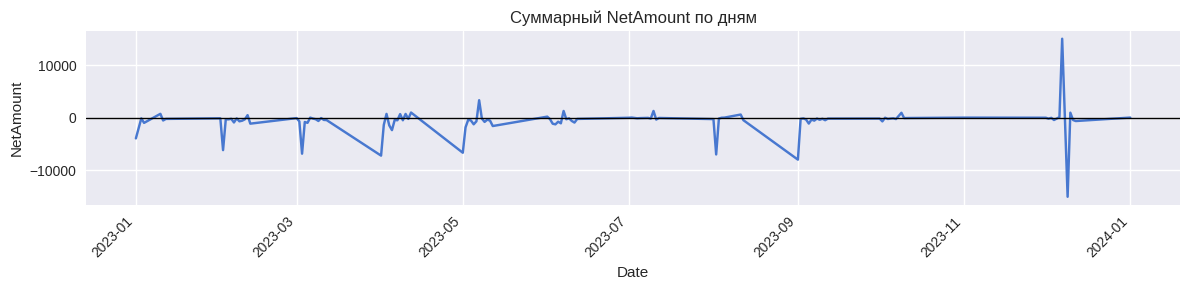

In [16]:
"""Гипотеза 16: суммарный дневной NetAmount показывает общую динамику денежных потоков по дням."""

daily_flow = df_eda.groupby("Date")["NetAmount"].sum().reset_index()

plt.figure(figsize=(12, 3))
sns.lineplot(data=daily_flow, x="Date", y="NetAmount")
plt.axhline(0, color="black", linewidth=1)
plt.title("Суммарный NetAmount по дням")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

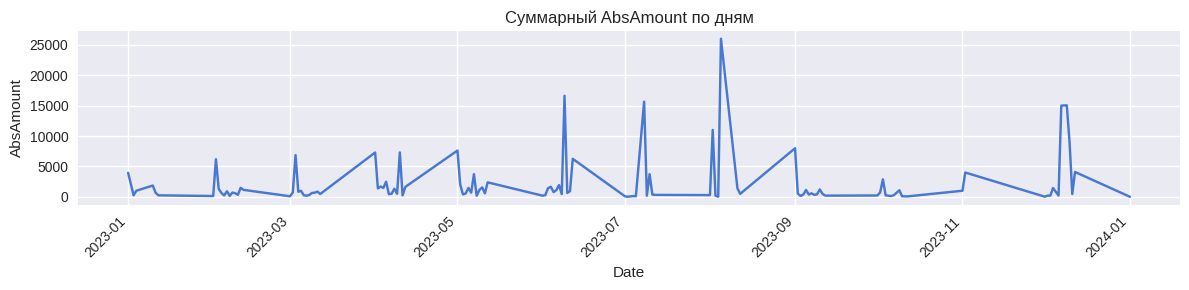

In [17]:
"""Гипотеза 17: ежедневный суммарный AbsAmount показывает уровень общей активности по счёту."""

daily_abs = df_eda.groupby("Date")["AbsAmount"].sum().reset_index()

plt.figure(figsize=(12, 3))
sns.lineplot(data=daily_abs, x="Date", y="AbsAmount")
plt.title("Суммарный AbsAmount по дням")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

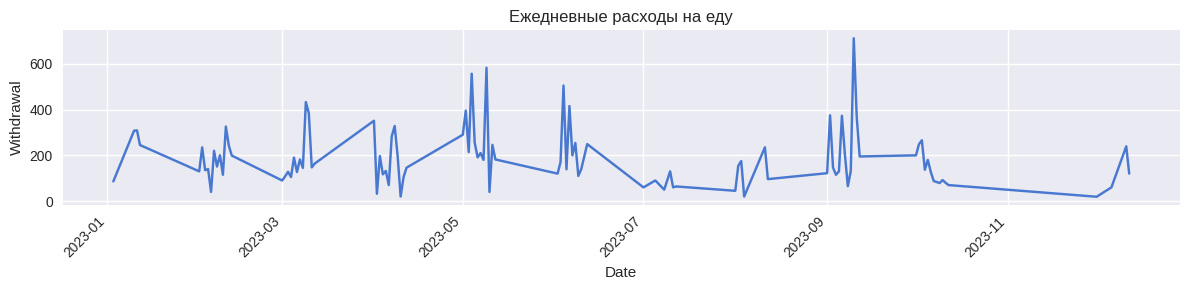

Количество дней с тратами на еду: 101


In [18]:
"""Гипотеза 18: траты на еду (Food) идут почти каждый день, формируя устойчивый паттерн."""

food_eda = df_eda[df_eda["Category"] == "Food"].copy()
daily_food = food_eda.groupby("Date")["Withdrawal"].sum().reset_index()

plt.figure(figsize=(12, 3))
sns.lineplot(data=daily_food, x="Date", y="Withdrawal")
plt.title("Ежедневные расходы на еду")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("Количество дней с тратами на еду:", daily_food["Date"].nunique())

WeekdayName
Пн    2600.53
Вт    3249.84
Ср    2564.23
Чт    2892.64
Пт    2513.96
Сб    2616.66
Вс    2593.54
Name: Withdrawal, dtype: float64

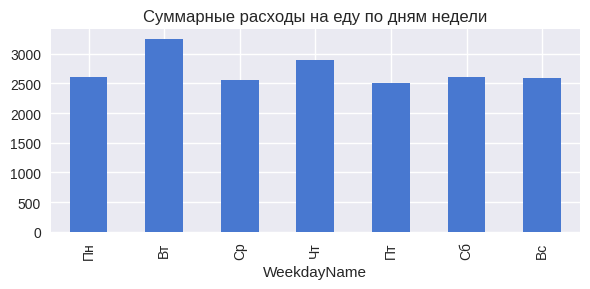

In [19]:
"""Гипотеза 19: расходы на еду различаются по дням недели (выходные vs будни)."""

food_eda["Weekday"] = food_eda["Date"].dt.weekday
weekday_map = {0: "Пн", 1: "Вт", 2: "Ср", 3: "Чт", 4: "Пт", 5: "Сб", 6: "Вс"}
food_eda["WeekdayName"] = food_eda["Weekday"].map(weekday_map)

weekday_food = (
    food_eda.groupby("WeekdayName")["Withdrawal"].sum().reindex(["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])
)

display(weekday_food)

plt.figure(figsize=(6, 3))
weekday_food.plot(kind="bar")
plt.title("Суммарные расходы на еду по дням недели")
plt.tight_layout()
plt.show()

Month
2023-01    39.479167
2023-02    47.409556
2023-03    52.479286
2023-04    58.159706
2023-05    59.714286
2023-06    56.180488
2023-07    32.428571
2023-08    40.277778
2023-09    66.745227
2023-10    54.049310
2023-12    43.829000
Freq: M, Name: Withdrawal, dtype: float64

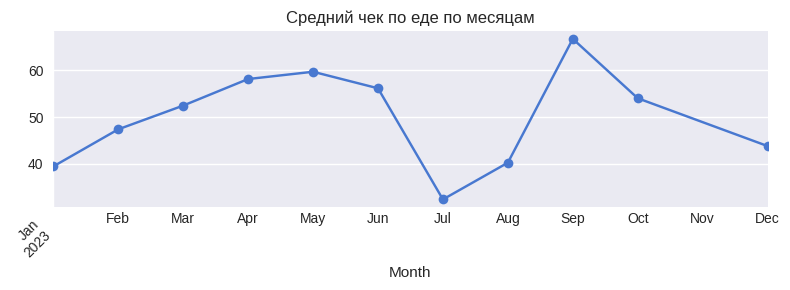

In [20]:
"""Гипотеза 20: средний чек по еде (Food) может расти или снижаться со временем (помесячный тренд)."""

food_eda["Month"] = food_eda["Date"].dt.to_period("M")
avg_check_month = food_eda.groupby("Month")["Withdrawal"].mean()

display(avg_check_month)

plt.figure(figsize=(8, 3))
avg_check_month.plot(marker="o")
plt.title("Средний чек по еде по месяцам")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Shopping транзакции:


,Date,Withdrawal,Deposit,NetAmount
77,2023-02-09,474.0,0.0,-474.0
90,2023-02-11,0.0,249.0,249.0
91,2023-02-11,261.0,0.0,-261.0
92,2023-02-11,0.0,225.0,225.0
176,2023-04-04,54.0,0.0,-54.0
181,2023-04-05,0.0,54.0,54.0
312,2023-06-01,0.0,186.0,186.0
325,2023-06-03,454.0,0.0,-454.0
395,2023-07-09,184.0,0.0,-184.0


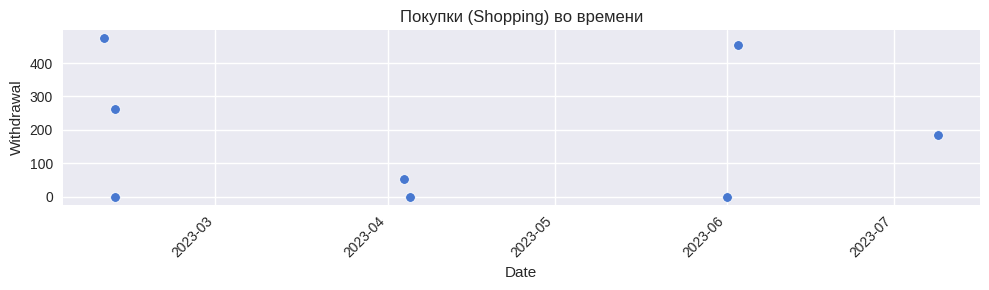

In [21]:
"""Гипотеза 21: покупки (Shopping) происходят неравномерно во времени и могут тяготеть к датам зарплаты."""

shop_eda = df_eda[df_eda["Category"] == "Shopping"].copy()
print("Shopping транзакции:")
display(shop_eda[["Date", "Withdrawal", "Deposit", "NetAmount"]].head(30))

plt.figure(figsize=(10, 3))
sns.scatterplot(data=shop_eda, x="Date", y="Withdrawal")
plt.title("Покупки (Shopping) во времени")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [22]:
"""Гипотеза 23: транспортные расходы (Transport) носят эпизодический и крупный характер."""

transport_eda = df_eda[df_eda["Category"] == "Transport"].copy()
print("Transport транзакции:")
display(transport_eda[["Date", "Withdrawal", "Deposit", "NetAmount", "Balance"]])

Transport транзакции:


,Date,Withdrawal,Deposit,NetAmount,Balance
555,2023-12-10,3062.0,0.0,-3062.0,1181.97
566,2023-12-12,1718.0,0.0,-1718.0,72.68


In [23]:
"""Гипотеза 24: структура расходов по категориям заметно различается между месяцами."""

pivot_month_cat = (
    df_eda.assign(Expense=df_eda["Withdrawal"].fillna(0))
    .groupby(["Month", "Category"])["Expense"]
    .sum()
    .reset_index()
)

display(pivot_month_cat.head())

,Month,Category,Expense
0,2023-01,Food,947.50
1,2023-01,Misc,1671.00
2,2023-01,Rent,3950.00
3,2023-02,Food,2133.43
4,2023-02,Misc,3527.00


,Month,Total,FoodExp,FoodShare,Month_str
0,2023-01,6568.50,947.50,0.144249,2023-01
1,2023-02,12171.43,2133.43,0.175282,2023-02
2,2023-03,12231.63,2204.13,0.180199,2023-03
3,2023-04,18679.43,1977.43,0.105861,2023-04
4,2023-05,16984.16,3344.00,0.196889,2023-05
5,2023-06,18797.41,2303.40,0.122538,2023-06
6,2023-07,10098.00,454.00,0.044959,2023-07
7,2023-08,23380.00,725.00,0.031009,2023-08
8,2023-09,13018.29,2936.79,0.225590,2023-09
9,2023-10,3521.43,1567.43,0.445112,2023-10


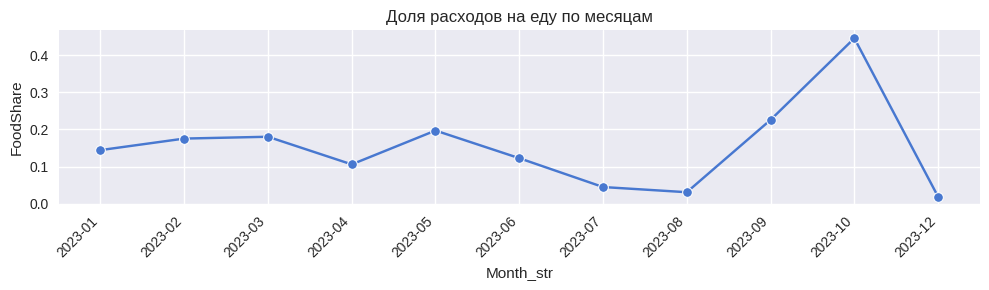

In [24]:
"""Гипотеза 25: доля категории Food в общих расходах по месяцам показывает стабильность питания как статьи бюджета."""

total_month_exp = pivot_month_cat.groupby("Month")["Expense"].sum().rename("Total")
food_month_exp = (
    pivot_month_cat[pivot_month_cat["Category"] == "Food"]
    .groupby("Month")["Expense"]
    .sum()
    .rename("FoodExp")
)

food_share_month = (
    pd.concat([total_month_exp, food_month_exp], axis=1)
    .dropna()
    .reset_index()
)
food_share_month["FoodShare"] = food_share_month["FoodExp"] / food_share_month["Total"]

# строковое представление месяца для оси X
food_share_month["Month_str"] = food_share_month["Month"].astype(str)

display(food_share_month)

plt.figure(figsize=(10, 3))
sns.lineplot(data=food_share_month, x="Month_str", y="FoodShare", marker="o")
plt.title("Доля расходов на еду по месяцам")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

,Month,Total,MiscExp,MiscShare,Month_str
0,2023-01,6568.50,1671.00,0.254396,2023-01
1,2023-02,12171.43,3527.00,0.289777,2023-02
2,2023-03,12231.63,3537.50,0.289209,2023-03
3,2023-04,18679.43,10292.00,0.550980,2023-04
4,2023-05,16984.16,7177.16,0.422580,2023-05
5,2023-06,18797.41,16040.01,0.853310,2023-06
6,2023-07,10098.00,9460.00,0.936819,2023-07
7,2023-08,23380.00,15196.00,0.649957,2023-08
8,2023-09,13018.29,2771.50,0.212893,2023-09
9,2023-10,3521.43,1954.00,0.554888,2023-10


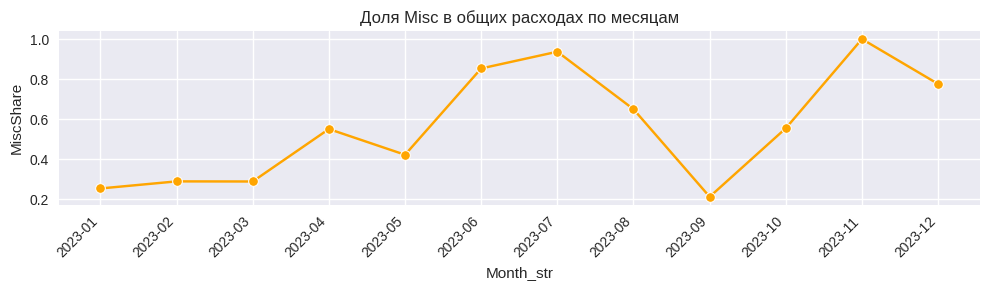

In [25]:
"""Гипотеза 26: доля категории Misc в общих расходах по месяцам отражает непредсказуемые/нерегулярные расходы."""

misc_month_exp = (
    pivot_month_cat[pivot_month_cat["Category"] == "Misc"]
    .groupby("Month")["Expense"]
    .sum()
    .rename("MiscExp")
)

misc_share_month = (
    pd.concat([total_month_exp, misc_month_exp], axis=1)
    .dropna()
    .reset_index()
)
misc_share_month["MiscShare"] = misc_share_month["MiscExp"] / misc_share_month["Total"]

misc_share_month["Month_str"] = misc_share_month["Month"].astype(str)

display(misc_share_month)

plt.figure(figsize=(10, 3))
sns.lineplot(data=misc_share_month, x="Month_str", y="MiscShare", marker="o", color="orange")
plt.title("Доля Misc в общих расходах по месяцам")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [26]:
"""Гипотеза 27: недельная структура расходов показывает цикличность внутри месяца (по неделям)."""

weekly_eda = (
    df_eda.assign(Expense=df_eda["Withdrawal"].fillna(0))
    .groupby(["Year", "Week", "Category"])["Expense"]
    .sum()
    .reset_index()
)

display(weekly_eda.head())

,Year,Week,Category,Expense
0,2023,1,Food,86.00
1,2023,1,Misc,1107.00
2,2023,2,Food,861.50
3,2023,2,Misc,564.00
4,2023,5,Food,679.87


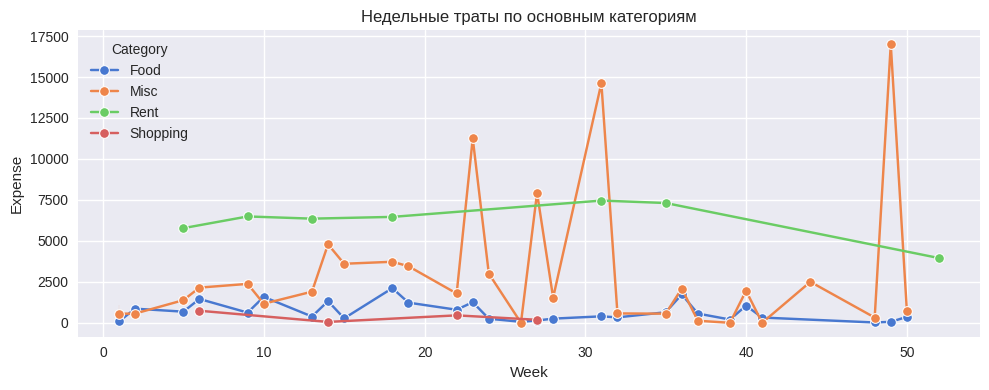

In [27]:
"""Гипотеза 28: по основным категориям (Food, Misc, Shopping, Rent) недельные траты имеют свой характерный уровень."""

main_cats = ["Food", "Misc", "Shopping", "Rent"]
weekly_main = weekly_eda[weekly_eda["Category"].isin(main_cats)].copy()

plt.figure(figsize=(10, 4))
sns.lineplot(data=weekly_main, x="Week", y="Expense", hue="Category", marker="o")
plt.title("Недельные траты по основным категориям")
plt.tight_layout()
plt.show()

,Date,Balance,Month,Month_str
30,2023-01-12,648.73,2023-01,2023-01
94,2023-02-12,1883.54,2023-02,2023-02
159,2023-03-12,306.26,2023-03,2023-03
220,2023-04-12,1959.51,2023-04,2023-04
306,2023-05-12,2255.36,2023-05,2023-05
382,2023-06-12,3068.55,2023-06,2023-06
405,2023-07-12,1398.94,2023-07,2023-07
439,2023-08-12,141.62,2023-08,2023-08
495,2023-09-12,45.33,2023-09,2023-09
535,2023-10-12,757.89,2023-10,2023-10


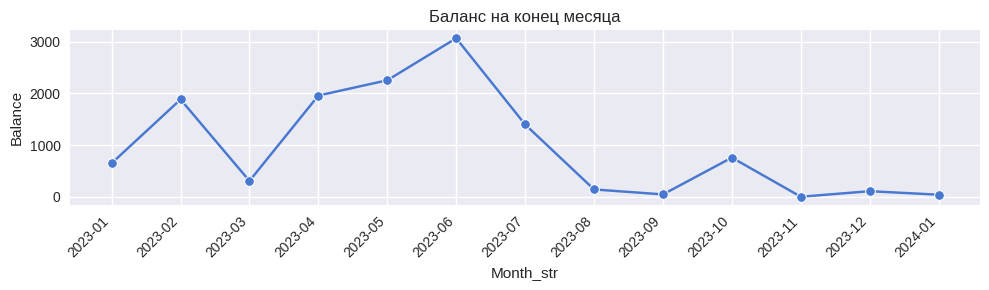

In [28]:
"""Гипотеза 29: баланс на конец каждого месяца показывает, в каком состоянии закрывается месяц."""

month_end = (
    df_eda.sort_values("Date")
    .groupby(df_eda["Date"].dt.to_period("M"))
    .tail(1)
)

month_end_stats = month_end[["Date", "Balance"]].copy()
month_end_stats["Month"] = month_end_stats["Date"].dt.to_period("M")
month_end_stats["Month_str"] = month_end_stats["Month"].astype(str)

display(month_end_stats)

plt.figure(figsize=(10, 3))
sns.lineplot(data=month_end_stats, x="Month_str", y="Balance", marker="o")
plt.title("Баланс на конец месяца")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [29]:
"""Гипотеза 30: есть 'дорогие' дни по еде, когда сумма трат сильно превышает обычный уровень."""

daily_food_sum = food_eda.groupby("Date")["Withdrawal"].sum().reset_index()
median_food = daily_food_sum["Withdrawal"].median()
expensive_days = daily_food_sum[daily_food_sum["Withdrawal"] > 2 * median_food]

print("Медианная дневная трата на еду:", median_food)
print("Дни с тратами > 2×медианы:")
display(expensive_days.sort_values("Withdrawal", ascending=False).head(20))

Медианная дневная трата на еду: 151.0
Дни с тратами > 2×медианы:


,Date,Withdrawal
83,2023-09-10,711.64
48,2023-05-09,582.75
43,2023-05-04,556.90
54,2023-06-04,504.90
24,2023-03-09,432.87
56,2023-06-06,415.50
41,2023-05-02,395.35
25,2023-03-10,384.96
75,2023-09-02,374.96
79,2023-09-06,372.95


In [30]:
"""Гипотеза 31: дни с очень большим общим расходом (Withdrawal) — 'стрессовые дни' бюджета."""

daily_withdraw = df_eda.groupby("Date")["Withdrawal"].sum().reset_index()
threshold_stress = daily_withdraw["Withdrawal"].quantile(0.95)
stress_days = daily_withdraw[daily_withdraw["Withdrawal"] >= threshold_stress].sort_values(
    "Withdrawal", ascending=False
)

print("Порог 95% по дневным расходам:", threshold_stress)
display(stress_days.head(30))

Порог 95% по дневным расходам: 7346.077499999995


,Date,Withdrawal
113,2023-12-09,15048.0
79,2023-08-05,13000.0
76,2023-08-02,9001.0
62,2023-06-09,8372.0
82,2023-09-01,7989.0
70,2023-07-08,7850.0


In [31]:
"""Гипотеза 32: в конце месяца (последние дни) структура расходов отличается от начала месяца."""

df_eda["DayOfMonth"] = df_eda["Date"].dt.day
begin_month = df_eda[df_eda["DayOfMonth"] <= 3]
end_month = df_eda[df_eda["DayOfMonth"] >= 28]

begin_cat = begin_month.groupby("Category")["Withdrawal"].sum().rename("Begin")
end_cat = end_month.groupby("Category")["Withdrawal"].sum().rename("End")

comp_begin_end = pd.concat([begin_cat, end_cat], axis=1).fillna(0)
display(comp_begin_end)

,Begin,End
Category,,
Food,4492.07,0.0
Misc,13600.17,0.0
Rent,43804.00,0.0
Shopping,454.00,0.0


,Date,TxnCount,NetAmount,AbsAmount,DailyBalance
0,2023-01-01,1,-3950.0,3950.0,1837.23
1,2023-01-03,5,-137.0,247.0,1700.23
2,2023-01-04,3,-1001.0,1001.0,699.23
3,2023-01-10,10,722.5,1855.5,1750.23
4,2023-01-11,11,-548.0,680.0,1338.73


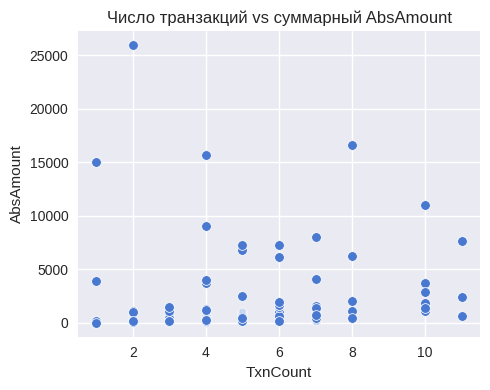

In [32]:
"""Гипотеза 33: количество операций за день и общий NetAmount связаны (чем больше движений, тем больше поток)."""

daily_stats = (
    df_eda.groupby("Date")
    .agg(
        TxnCount=("Category", "count"),
        NetAmount=("NetAmount", "sum"),
        AbsAmount=("AbsAmount", "sum"),
        DailyBalance=("Balance", "last"),
    )
    .reset_index()
)

display(daily_stats.head())

plt.figure(figsize=(5, 4))
sns.scatterplot(data=daily_stats, x="TxnCount", y="AbsAmount")
plt.title("Число транзакций vs суммарный AbsAmount")
plt.tight_layout()
plt.show()

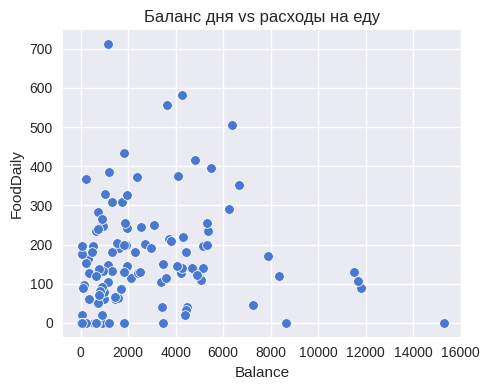

In [33]:
"""Гипотеза 34: дневной баланс и траты на еду в этот день отрицательно коррелируют (при низком балансе тратим меньше)."""

daily_food_bal = (
    df_eda.merge(
        food_eda.groupby("Date")["Withdrawal"].sum().rename("FoodDaily"),
        on="Date",
        how="left",
    )
    .groupby("Date")
    .agg(Balance=("Balance", "last"), FoodDaily=("FoodDaily", "max"))
    .fillna({"FoodDaily": 0})
    .reset_index()
)

plt.figure(figsize=(5, 4))
sns.scatterplot(data=daily_food_bal, x="Balance", y="FoodDaily")
plt.title("Баланс дня vs расходы на еду")
plt.tight_layout()
plt.show()

In [34]:
"""Гипотеза 35: месячные агрегаты по категориям (матрица Month x Category) позволяют увидеть 'подпись' месяца."""

month_cat_matrix = (
    df_eda.assign(Expense=df_eda["Withdrawal"].fillna(0))
    .pivot_table(index="Month", columns="Category", values="Expense", aggfunc="sum")
    .fillna(0)
)

display(month_cat_matrix.head())

Category,Food,Misc,Rent,Shopping,Transport
Month,,,,,
2023-01,947.50,1671.00,3950.0,0.0,0.0
2023-02,2133.43,3527.00,5776.0,735.0,0.0
2023-03,2204.13,3537.50,6490.0,0.0,0.0
2023-04,1977.43,10292.00,6356.0,54.0,0.0
2023-05,3344.00,7177.16,6463.0,0.0,0.0


In [35]:
"""Гипотеза 36: доля Food от зарплаты (Salary) по месяцам показывает, сколько дохода съедает еда."""

monthly_food = (
    df_eda[df_eda["Category"] == "Food"]
    .groupby("Month")["Withdrawal"]
    .sum()
    .rename("FoodSpend")
)
monthly_salary = (
    df_eda[df_eda["Category"] == "Salary"]
    .groupby("Month")["Deposit"]
    .sum()
    .rename("SalaryIncome")
)

ratio_food_salary = pd.concat([monthly_food, monthly_salary], axis=1).dropna()

if ratio_food_salary.empty:
    print("Нет месяцев, где одновременно есть Food и Salary — график Food/Salarу не строится.")
    display(monthly_food.to_frame().rename(columns={"FoodSpend": "FoodSpend_only"}))
    display(monthly_salary.to_frame().rename(columns={"SalaryIncome": "SalaryIncome_only"}))
else:
    ratio_food_salary["FoodToSalary"] = ratio_food_salary["FoodSpend"] / ratio_food_salary["SalaryIncome"]
    display(ratio_food_salary)

    plt.figure(figsize=(8, 3))
    ratio_food_salary["FoodToSalary"].plot(marker="o")
    plt.title("Доля Food от Salary по месяцам")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

Нет месяцев, где одновременно есть Food и Salary — график Food/Salarу не строится.


,FoodSpend_only
Month,
2023-01,947.50
2023-02,2133.43
2023-03,2204.13
2023-04,1977.43
2023-05,3344.00
2023-06,2303.40
2023-07,454.00
2023-08,725.00
2023-09,2936.79


,SalaryIncome_only
Month,


In [36]:
"""Гипотеза 37: доля Rent от зарплаты показывает нагрузку аренды на доход."""

monthly_rent = (
    df_eda[df_eda["Category"] == "Rent"]
    .groupby("Month")["Withdrawal"]
    .sum()
    .rename("RentSpend")
)

ratio_rent_salary = pd.concat([monthly_rent, monthly_salary], axis=1).dropna()

if ratio_rent_salary.empty:
    print("Нет месяцев, где одновременно есть Rent и Salary — график Rent/Salary не строится.")
    display(monthly_rent.to_frame().rename(columns={"RentSpend": "RentSpend_only"}))
    display(monthly_salary.to_frame().rename(columns={"SalaryIncome": "SalaryIncome_only"}))
else:
    ratio_rent_salary["RentToSalary"] = ratio_rent_salary["RentSpend"] / ratio_rent_salary["SalaryIncome"]
    display(ratio_rent_salary)

    plt.figure(figsize=(8, 3))
    ratio_rent_salary["RentToSalary"].plot(marker="o", color="red")
    plt.title("Доля Rent от Salary по месяцам")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

Нет месяцев, где одновременно есть Rent и Salary — график Rent/Salary не строится.


,RentSpend_only
Month,
2023-01,3950.0
2023-02,5776.0
2023-03,6490.0
2023-04,6356.0
2023-05,6463.0
2023-08,7459.0
2023-09,7310.0


,SalaryIncome_only
Month,


In [37]:
"""Гипотеза 38: влияние арендного платежа на баланс видно как резкий спад вокруг даты Rent."""

import numpy as np

impact_rows = []

# Если по каким-то причинам rent_eda ещё не определён или пустой — просто сообщаем и выходим
if "rent_eda" not in globals() or rent_eda.empty:
    print("Нет арендных транзакций для анализа влияния на баланс.")
else:
    rent_eda_sorted = rent_eda.sort_values("Date")
    for _, r in rent_eda_sorted.iterrows():
        date = r["Date"]
        # последний баланс ДО аренды
        before_series = df_eda[df_eda["Date"] < date].tail(1)["Balance"]
        # первый баланс ПОСЛЕ аренды
        after_series = df_eda[df_eda["Date"] > date].head(1)["Balance"]
        impact_rows.append(
            {
                "RentDate": date,
                "RentWithdrawal": r["Withdrawal"],
                "BalanceBefore": before_series.iloc[0] if not before_series.empty else np.nan,
                "BalanceAfter": after_series.iloc[0] if not after_series.empty else np.nan,
            }
        )

    rent_impact = pd.DataFrame(impact_rows)
    display(rent_impact)

,RentDate,RentWithdrawal,BalanceBefore,BalanceAfter
0,2023-01-01,3950.0,NaN,1732.23
1,2023-02-02,5776.0,11526.97,5021.10
2,2023-03-03,6490.0,11668.89,4125.89
3,2023-04-01,6356.0,306.26,5795.79
4,2023-05-01,6463.0,1959.51,4094.01
5,2023-08-02,7459.0,7240.62,144.62
6,2023-09-01,7310.0,141.62,4169.66


In [38]:
"""Гипотеза 39: крупные Misc-платежи (например, депозиты, переводы) можно выделить по порогу."""

misc_eda = df_eda[df_eda["Category"] == "Misc"].copy()
threshold_misc = misc_eda["Withdrawal"].quantile(0.9)
big_misc = misc_eda[misc_eda["Withdrawal"] >= threshold_misc]

print("Порог крупных Misc (90-й перцентиль):", threshold_misc)
display(big_misc[["Date", "Withdrawal", "Deposit", "Balance"]].sort_values("Withdrawal", ascending=False).head(30))

Порог крупных Misc (90-й перцентиль): 690.0


,Date,Withdrawal,Deposit,Balance
553,2023-12-09,15048.00,0.0,243.97
429,2023-08-05,13000.00,0.0,44.62
360,2023-06-09,8000.00,0.0,5016.55
394,2023-07-08,7800.00,0.0,745.98
208,2023-04-10,3000.00,0.0,1395.51
378,2023-06-12,3000.00,0.0,3233.55
182,2023-04-05,2000.00,0.0,1742.79
232,2023-05-02,1391.16,0.0,4094.01
168,2023-04-02,1200.00,0.0,4445.79
398,2023-07-10,1100.00,0.0,1861.98


In [39]:
"""Гипотеза 40: сводная таблица по месяцам (доходы, расходы, Food, Rent, Shopping, баланс) даёт общую картину бюджета."""

monthly_index = pd.Index(df_eda["Month"].unique()).sort_values()
monthly_summary = pd.DataFrame(index=monthly_index)
monthly_summary["IncomeTotal"] = df_eda.groupby("Month")["Deposit"].sum()
monthly_summary["ExpenseTotal"] = df_eda.groupby("Month")["Withdrawal"].sum()
monthly_summary["Food"] = df_eda[df_eda["Category"] == "Food"].groupby("Month")["Withdrawal"].sum()
monthly_summary["Rent"] = df_eda[df_eda["Category"] == "Rent"].groupby("Month")["Withdrawal"].sum()
monthly_summary["Shopping"] = df_eda[df_eda["Category"] == "Shopping"].groupby("Month")["Withdrawal"].sum()

month_end_bal = (
    df_eda.sort_values("Date")
    .groupby(df_eda["Date"].dt.to_period("M"))
    .tail(1)
    .set_index("Month")["Balance"]
)
monthly_summary["EndBalance"] = month_end_bal

monthly_summary = monthly_summary.fillna(0)
display(monthly_summary)

,IncomeTotal,ExpenseTotal,Food,Rent,Shopping,EndBalance
2023-01,1410.00,6568.50,947.50,3950.0,0.0,648.73
2023-02,1626.00,12171.43,2133.43,5776.0,735.0,1883.54
2023-03,641.00,12231.63,2204.13,6490.0,0.0,306.26
2023-04,7586.00,18679.43,1977.43,6356.0,54.0,1959.51
2023-05,5296.00,16984.16,3344.00,6463.0,0.0,2255.36
2023-06,13414.00,18797.41,2303.40,0.0,454.0,3068.55
2023-07,10471.09,10098.00,454.00,0.0,184.0,1398.94
2023-08,16000.00,23380.00,725.00,7459.0,0.0,141.62
2023-09,716.76,13018.29,2936.79,7310.0,0.0,45.33
2023-10,2448.00,3521.43,1567.43,0.0,0.0,757.89


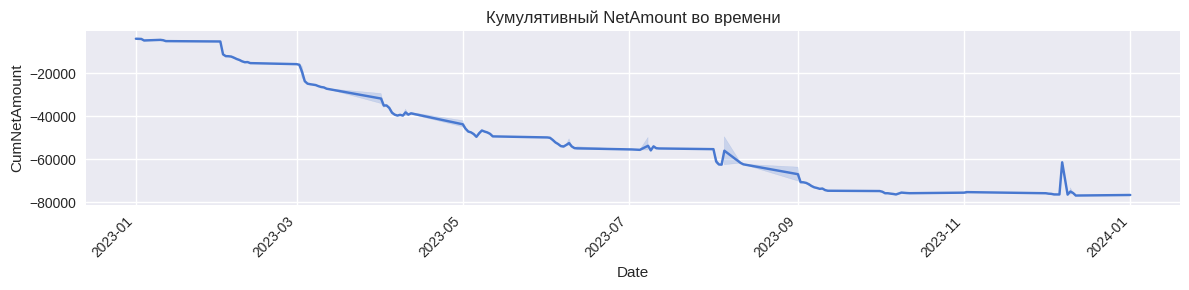

In [40]:
"""Гипотеза 41: кумулятивный NetAmount показывает долгосрочный тренд по счёту (нарастающий итог)."""

df_eda = df_eda.sort_values("Date")
df_eda["CumNetAmount"] = df_eda["NetAmount"].cumsum()

plt.figure(figsize=(12, 3))
sns.lineplot(data=df_eda, x="Date", y="CumNetAmount")
plt.title("Кумулятивный NetAmount во времени")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

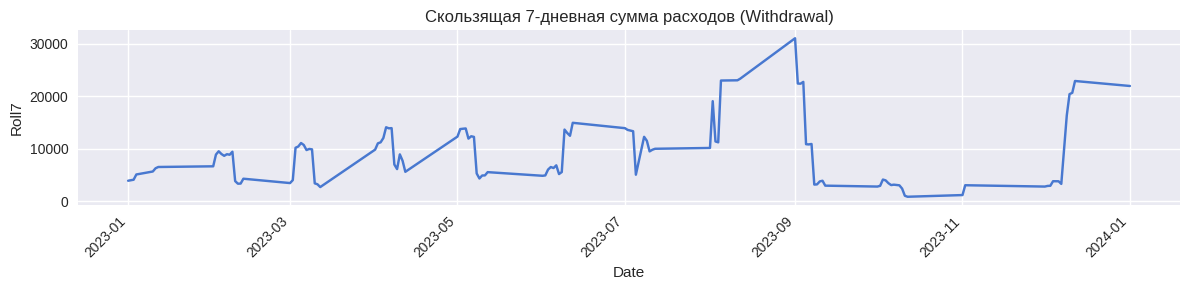

In [41]:
"""Гипотеза 42: скользящая 7-дневная сумма расходов показывает сглаженные пики трат."""

daily_withdraw_7 = df_eda.groupby("Date")["Withdrawal"].sum().reset_index()
daily_withdraw_7["Roll7"] = daily_withdraw_7["Withdrawal"].rolling(7, min_periods=1).sum()

plt.figure(figsize=(12, 3))
sns.lineplot(data=daily_withdraw_7, x="Date", y="Roll7")
plt.title("Скользящая 7-дневная сумма расходов (Withdrawal)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

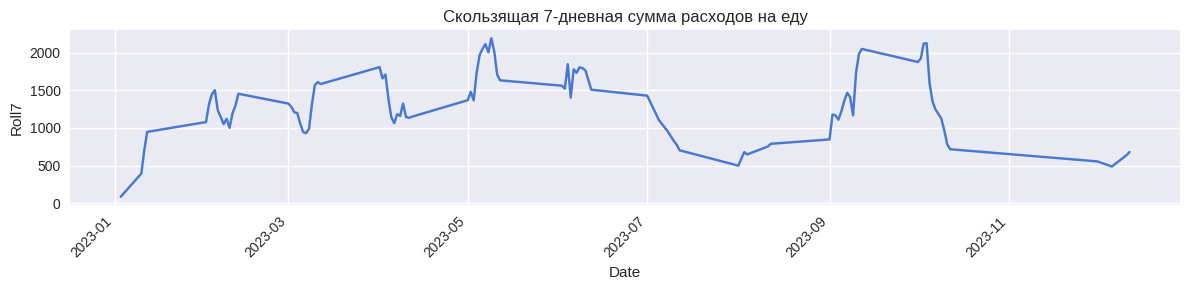

In [42]:
"""Гипотеза 43: скользящая 7-дневная сумма по Food показывает тренд изменения расхода на еду."""

daily_food_7 = food_eda.groupby("Date")["Withdrawal"].sum().reset_index()
daily_food_7["Roll7"] = daily_food_7["Withdrawal"].rolling(7, min_periods=1).sum()

plt.figure(figsize=(12, 3))
sns.lineplot(data=daily_food_7, x="Date", y="Roll7")
plt.title("Скользящая 7-дневная сумма расходов на еду")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [43]:
"""Гипотеза 44: интервалы между арендными платежами (Rent) близки к одному месяцу."""

if len(rent_eda) > 1:
    rent_eda = rent_eda.sort_values("Date")
    rent_eda["DaysSincePrevRent"] = rent_eda["Date"].diff().dt.days
    display(rent_eda[["Date", "Withdrawal", "DaysSincePrevRent"]])

,Date,Withdrawal,DaysSincePrevRent
0,2023-01-01,3950.0,NaN
40,2023-02-02,5776.0,32.0
111,2023-03-03,6490.0,29.0
163,2023-04-01,6356.0,29.0
228,2023-05-01,6463.0,30.0
414,2023-08-02,7459.0,93.0
445,2023-09-01,7310.0,30.0


In [44]:
"""Гипотеза 45: интервалы между Transport-операциями показывают, что это разовые события, а не регулярные."""

if len(transport_eda) > 1:
    transport_eda = transport_eda.sort_values("Date")
    transport_eda["DaysSincePrevTransport"] = transport_eda["Date"].diff().dt.days
    display(transport_eda[["Date", "Withdrawal", "DaysSincePrevTransport"]])

,Date,Withdrawal,DaysSincePrevTransport
555,2023-12-10,3062.0,NaN
566,2023-12-12,1718.0,2.0


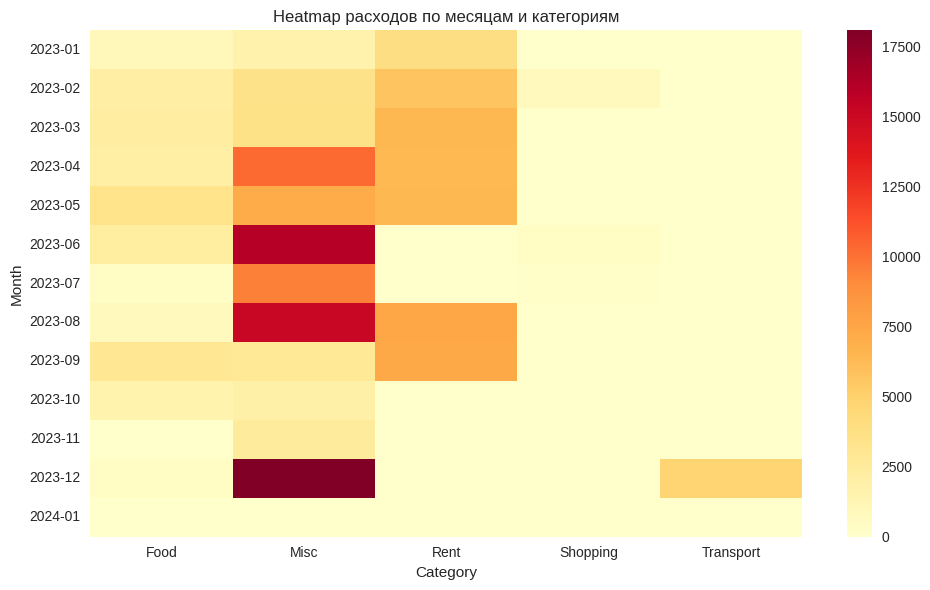

In [45]:
"""Гипотеза 46: тепловая карта (Month x Category) по расходам показывает, в какие месяцы какие категории доминируют."""

heat_data = month_cat_matrix.copy()
# Переведём Period в строку для аккуратной подписи
heat_data.index = heat_data.index.astype(str)

plt.figure(figsize=(10, 6))
sns.heatmap(heat_data, cmap="YlOrRd")
plt.title("Heatmap расходов по месяцам и категориям")
plt.ylabel("Month")
plt.xlabel("Category")
plt.tight_layout()
plt.show()

In [46]:
"""Гипотеза 47: месяцы можно кластеризовать по структуре расходов (кластеры 'типичных' месяцев)."""

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X_month = month_cat_matrix.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_month)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
month_clusters = kmeans.fit_predict(X_scaled)

clusters_df = pd.DataFrame({"Month": month_cat_matrix.index.astype(str), "Cluster": month_clusters})
display(clusters_df.sort_values("Month"))

,Month,Cluster
0,2023-01,1
1,2023-02,0
2,2023-03,0
3,2023-04,0
4,2023-05,0
5,2023-06,0
6,2023-07,1
7,2023-08,0
8,2023-09,0
9,2023-10,1


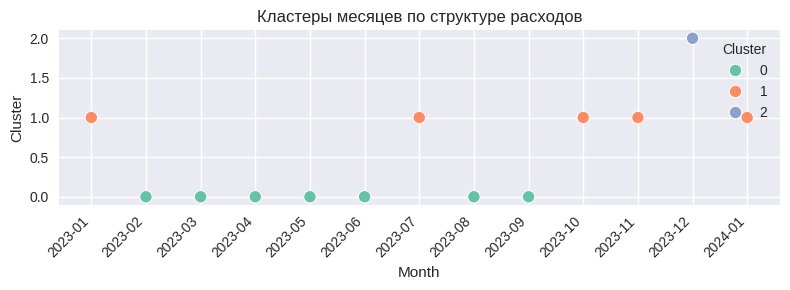

In [47]:
"""Гипотеза 48: визуализация кластеров месячных расходов показывает, какие месяцы похожи друг на друга."""

plt.figure(figsize=(8, 3))
sns.scatterplot(data=clusters_df, x="Month", y="Cluster", hue="Cluster", palette="Set2", s=80)
plt.title("Кластеры месяцев по структуре расходов")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [48]:
"""Гипотеза 49: аномальные дни по расходам можно выделить через z-score дневных Withdrawals."""

daily_withdraw_z = daily_withdraw.copy()
mu = daily_withdraw_z["Withdrawal"].mean()
sigma = daily_withdraw_z["Withdrawal"].std(ddof=0)
daily_withdraw_z["Z"] = (daily_withdraw_z["Withdrawal"] - mu) / (sigma + 1e-9)

anomalies = daily_withdraw_z[daily_withdraw_z["Z"].abs() > 2.5]
print("Аномальные дни по Z-score (|Z| > 2.5):")
display(anomalies.sort_values("Z", ascending=False).head(30))

Аномальные дни по Z-score (|Z| > 2.5):


,Date,Withdrawal,Z
113,2023-12-09,15048.0,5.411479
79,2023-08-05,13000.0,4.601434
76,2023-08-02,9001.0,3.019709
62,2023-06-09,8372.0,2.770921
82,2023-09-01,7989.0,2.619433
70,2023-07-08,7850.0,2.564454


In [49]:
"""Гипотеза 50: есть дни, когда Misc занимает непропорционально большую долю всех расходов."""

daily_misc = df_eda[df_eda["Category"] == "Misc"].groupby("Date")["Withdrawal"].sum().rename("MiscSpend")
daily_total = df_eda.groupby("Date")["Withdrawal"].sum().rename("TotalSpend")

misc_share_daily = pd.concat([daily_misc, daily_total], axis=1).dropna()
misc_share_daily["MiscShare"] = misc_share_daily["MiscSpend"] / misc_share_daily["TotalSpend"]

display(misc_share_daily.sort_values("MiscShare", ascending=False).head(30))

,MiscSpend,TotalSpend,MiscShare
Date,,,
2023-01-04,1001.0,1001.0,1.000000
2023-11-02,2000.0,2000.0,1.000000
2023-08-05,13000.0,13000.0,1.000000
2023-12-03,120.0,120.0,1.000000
2023-12-04,950.0,950.0,1.000000
2023-12-09,15048.0,15048.0,1.000000
2023-12-02,200.0,200.0,1.000000
2023-11-01,500.0,500.0,1.000000
2023-07-04,125.0,125.0,1.000000


In [50]:
"""Гипотеза 51: месяцы, где встречаются и Rent, и Transport, могут быть связаны с переездом/изменением аренды."""

month_has_rent = set(rent_eda["Date"].dt.to_period("M")) if not rent_eda.empty else set()
month_has_trans = set(transport_eda["Date"].dt.to_period("M")) if not transport_eda.empty else set()

both = sorted(month_has_rent.intersection(month_has_trans))
print("Месяцы, где есть и Rent, и Transport:", both)

Месяцы, где есть и Rent, и Transport: []


In [51]:
"""Гипотеза 52: существуют дни с очень низким балансом — потенциальная 'зона риска' по ликвидности."""

low_balance_days = df_eda.groupby("Date")["Balance"].last().sort_values().head(30)
print("Дни с минимальным балансом:")
display(low_balance_days)

Дни с минимальным балансом:


Date
2023-11-02      0.15
2023-11-01      0.15
2024-01-01     39.68
2023-08-05     44.62
2023-08-04     44.62
2023-09-12     45.33
2023-08-03     64.62
2023-10-07     78.89
2023-12-12    107.68
2023-08-12    141.62
2023-12-04    201.97
2023-08-02    239.62
2023-09-11    240.33
2023-12-09    243.97
2023-10-03    285.58
2023-12-06    291.97
2023-03-12    306.26
2023-10-06    350.58
2023-10-05    478.58
2023-04-09    533.51
2023-07-09    561.98
2023-08-11    630.62
2023-01-12    648.73
2023-12-03    651.97
2023-10-04    658.58
2023-04-07    658.79
2023-12-02    694.97
2023-01-04    699.23
2023-09-10    713.51
2023-12-11    722.68
Name: Balance, dtype: float64

Category
Misc         0.715608
Rent         0.178211
Food         0.078024
Transport    0.019447
Shopping     0.008710
Name: AbsShare, dtype: float64

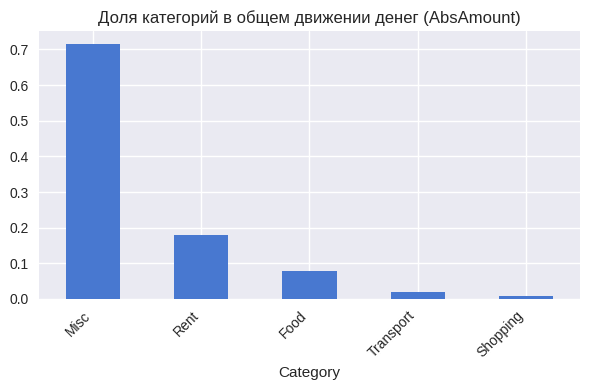

In [52]:
"""Гипотеза 53: доля каждой категории в суммарном AbsAmount показывает общую структуру расходов/доходов."""

cat_share_total = (
    df_eda.groupby("Category")["AbsAmount"].sum()
    .sort_values(ascending=False)
    .rename("AbsSum")
)
total_abs = cat_share_total.sum()
cat_share_total = (cat_share_total / total_abs).rename("AbsShare")

display(cat_share_total)

plt.figure(figsize=(6, 4))
cat_share_total.plot(kind="bar")
plt.title("Доля категорий в общем движении денег (AbsAmount)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [53]:
"""Гипотеза 54: некоторые категории (например, Transport) появляются только в конце периода и могут быть сложны для обучения моделей."""

cat_first_last = (
    df_eda.groupby("Category")["Date"]
    .agg(["min", "max"])
    .rename(columns={"min": "FirstDate", "max": "LastDate"})
)
display(cat_first_last)

,FirstDate,LastDate
Category,,
Food,2023-01-03,2023-12-12
Misc,2023-01-03,2024-01-01
Rent,2023-01-01,2023-09-01
Shopping,2023-02-09,2023-07-09
Transport,2023-12-10,2023-12-12


In [54]:
"""Гипотеза 55: группы по RefNo (Ref_Group) отражают разных контрагентов; есть особо частые Ref_Group."""

df_eda["Ref_Group"] = df_eda["RefNo"].astype(str).str[:6]
ref_group_counts = df_eda["Ref_Group"].value_counts().head(20)

print("Топ-20 Ref_Group по числу транзакций:")
display(ref_group_counts)

top_refs = df_eda[df_eda["Ref_Group"].isin(ref_group_counts.index)]
pivot_ref_cat = (
    top_refs.pivot_table(index="Ref_Group", columns="Category", values="AbsAmount", aggfunc="sum")
    .fillna(0)
)
display(pivot_ref_cat)

Топ-20 Ref_Group по числу транзакций:


Ref_Group
3.49E+    40
3.25E+    36
3.52E+    27
3.43E+    24
3.53E+    23
3.04E+    22
3.40E+    22
3.50E+    22
3.28E+    22
3.10E+    21
3.07E+    21
3.13E+    18
3.46E+    16
3.16E+    15
3.38E+    14
3.01E+    14
3.41E+    13
3.22E+    13
3.47E+    13
3.21E+    12
Name: count, dtype: int64

Category,Food,Misc,Rent,Shopping
Ref_Group,,,,
3.01E+,393.00,182.00,0.0,0.0
3.04E+,525.28,2517.00,0.0,1209.0
3.07E+,885.96,1384.59,0.0,0.0
3.10E+,650.28,11720.00,0.0,54.0
3.13E+,553.00,3197.00,0.0,0.0
3.16E+,407.00,6372.00,0.0,0.0
3.21E+,199.00,3388.00,7459.0,0.0
3.22E+,401.00,14572.00,0.0,0.0
3.25E+,1731.70,1104.50,0.0,0.0


In [55]:
"""Гипотеза 56: у зарплаты и аренды могут быть стабильные Ref_Group — те же контрагенты со временем."""

salary_refs = set(df_eda[df_eda["Category"] == "Salary"]["Ref_Group"].unique())
rent_refs = set(df_eda[df_eda["Category"] == "Rent"]["Ref_Group"].unique())

print("Ref_Group для Salary:", salary_refs)
print("Ref_Group для Rent:", rent_refs)
print("Пересечение (если есть):", salary_refs.intersection(rent_refs))

Ref_Group для Salary: set()
Ref_Group для Rent: {'3.09E+', '3.03E+', '3.21E+', '3.00E+', '3.12E+', '3.24E+', '3.06E+'}
Пересечение (если есть): set()


In [56]:
"""Гипотеза 57: можно построить простую rule-based эвристику для Salary/Rent на основе Ref_Group и суммы."""

def simple_rule_based(row):
    if row["Category"] in ["Salary", "Rent"]:
        return row["Category"]
    if row["Ref_Group"] in salary_refs and row["Deposit"] > 0:
        return "Salary_like"
    if row["Ref_Group"] in rent_refs and row["Withdrawal"] > 0:
        return "Rent_like"
    return "Other"

df_eda["RuleTag"] = df_eda.apply(simple_rule_based, axis=1)
display(df_eda["RuleTag"].value_counts())

RuleTag
Other        511
Rent_like     53
Rent           7
Name: count, dtype: int64

In [57]:
"""Гипотеза 58: сохранение очищенного и обогащённого df_eda пригодится для последующего моделирования."""

output_path = "TransFiles_3rzk6/ci_data_eda_prepared.csv"
df_eda.to_csv(output_path, index=False)
print("EDA-подготовленный датасет сохранён в:", output_path)

EDA-подготовленный датасет сохранён в: TransFiles_3rzk6/ci_data_eda_prepared.csv


In [58]:
"""Гипотеза 59: краткий текстовый отчёт по ключевым цифрам (кол-во месяцев, зарплат, аренд, транспортных операций)."""

num_months = df_eda["Month"].nunique()
num_salaries = len(salary_eda)
num_rents = len(rent_eda)
num_transports = len(transport_eda)

print(f"Всего месяцев в данных: {num_months}")
print(f"Число зарплатных транзакций: {num_salaries}")
print(f"Число арендных транзакций: {num_rents}")
print(f"Число транспортных транзакций: {num_transports}")
print(f"Период: {df_eda['Date'].min().date()} → {df_eda['Date'].max().date()}")

Всего месяцев в данных: 13
Число зарплатных транзакций: 0
Число арендных транзакций: 7
Число транспортных транзакций: 2
Период: 2023-01-01 → 2024-01-01


Дней с балансом ниже 500: 19 из 118


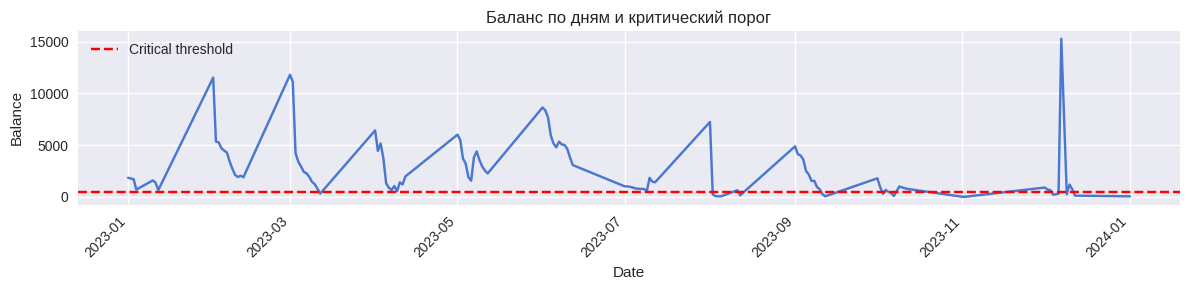

In [59]:
"""Гипотеза 61: оценим, сколько раз за период баланс падал ниже критического порога (например, 500 у.е.)."""

CRITICAL_BAL = 500

daily_bal = df_eda.groupby("Date")["Balance"].last().reset_index()
daily_bal["BelowCritical"] = (daily_bal["Balance"] < CRITICAL_BAL).astype(int)

print(f"Дней с балансом ниже {CRITICAL_BAL}: {daily_bal['BelowCritical'].sum()} из {len(daily_bal)}")

plt.figure(figsize=(12, 3))
sns.lineplot(data=daily_bal, x="Date", y="Balance")
plt.axhline(CRITICAL_BAL, color="red", linestyle="--", label="Critical threshold")
plt.title("Баланс по дням и критический порог")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


,Month,StressIndex,Month_str
12,2024-01,1.000000,2024-01
10,2023-11,1.000000,2023-11
7,2023-08,0.714286,2023-08
11,2023-12,0.400000,2023-12
9,2023-10,0.363636,2023-10
8,2023-09,0.166667,2023-09
2,2023-03,0.083333,2023-03
1,2023-02,0.000000,2023-02
0,2023-01,0.000000,2023-01
4,2023-05,0.000000,2023-05


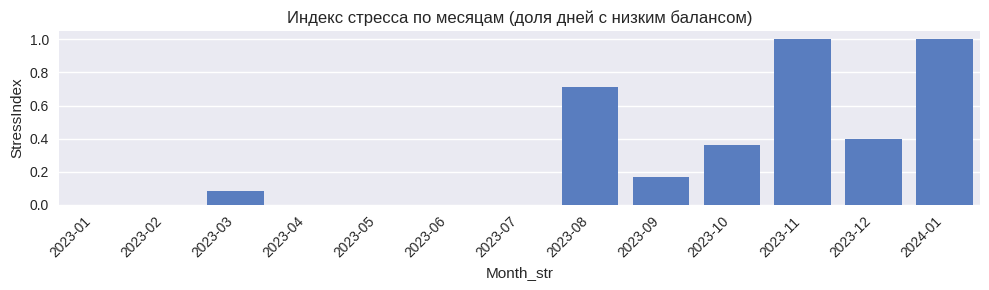

In [60]:
"""Гипотеза 62: посчитаем 'индекс стресса' по месяцам — доля дней с балансом ниже CRITICAL_BAL."""

daily_bal["Month"] = daily_bal["Date"].dt.to_period("M")
stress_month = (
    daily_bal.groupby("Month")["BelowCritical"]
    .mean()
    .rename("StressIndex")
    .reset_index()
)
stress_month["Month_str"] = stress_month["Month"].astype(str)

display(stress_month.sort_values("StressIndex", ascending=False))

plt.figure(figsize=(10, 3))
sns.barplot(data=stress_month, x="Month_str", y="StressIndex")
plt.title("Индекс стресса по месяцам (доля дней с низким балансом)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


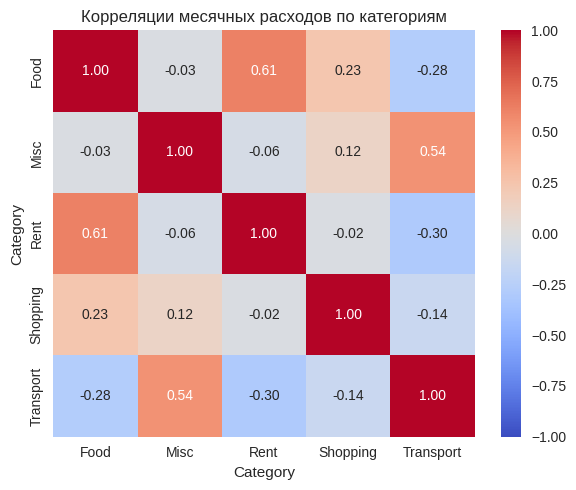

In [61]:
"""Гипотеза 63: проверим корреляции между месячными расходами по разным категориям (матрица корреляций)."""

corr_month = month_cat_matrix.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_month, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляции месячных расходов по категориям")
plt.tight_layout()
plt.show()


In [62]:
"""Гипотеза 64: найдём последовательности подряд идущих дней с низким балансом (финансовый 'стресс-период')."""

# Сортируем и нумеруем последовательности
daily_bal = daily_bal.sort_values("Date").reset_index(drop=True)
daily_bal["LowSeq"] = (daily_bal["BelowCritical"] & ~daily_bal["BelowCritical"].shift(fill_value=0)).cumsum()
low_seq_groups = daily_bal[daily_bal["BelowCritical"] == 1].groupby("LowSeq")

stress_periods = []
for k, g in low_seq_groups:
    stress_periods.append(
        {
            "SeqID": int(k),
            "StartDate": g["Date"].min(),
            "EndDate": g["Date"].max(),
            "LengthDays": len(g),
        }
    )

stress_periods_df = pd.DataFrame(stress_periods).sort_values("LengthDays", ascending=False)
display(stress_periods_df.head(10))


,SeqID,StartDate,EndDate,LengthDays
1,2,2023-08-02,2023-08-05,4
5,6,2023-10-05,2023-10-07,3
9,10,2023-12-12,2024-01-01,2
3,4,2023-09-11,2023-09-12,2
7,8,2023-12-04,2023-12-06,2
6,7,2023-11-01,2023-11-02,2
0,1,2023-03-12,2023-03-12,1
2,3,2023-08-12,2023-08-12,1
4,5,2023-10-03,2023-10-03,1
8,9,2023-12-09,2023-12-09,1


In [63]:
"""Гипотеза 65: посмотрим, как ведёт себя расход на еду в периоды финансового стресса (низкий баланс)."""

# Мержим daily_food_bal (Balance vs FoodDaily) с флагом 'ниже порога'
stress_merge = daily_food_bal.merge(
    daily_bal[["Date", "BelowCritical"]],
    on="Date",
    how="left",
)
stress_merge["BelowCritical"] = stress_merge["BelowCritical"].fillna(0).astype(int)

group_stats = (
    stress_merge.groupby("BelowCritical")["FoodDaily"]
    .describe()[["mean", "50%", "max"]]
    .rename(index={0: "Normal", 1: "LowBalance"})
)

print("Статистика расходов на еду при нормальном и низком балансе:")
display(group_stats)


Статистика расходов на еду при нормальном и низком балансе:


,mean,50%,max
BelowCritical,,,
Normal,171.906364,140.0,711.64
LowBalance,105.930000,96.0,367.24


,FoodTotal,RentTotal,OtherTotal,Mandatory,Other,Month_str
Month,,,,,,
2023-01,947.50,3950.0,1671.00,4897.50,1671.00,2023-01
2023-02,2133.43,5776.0,4262.00,7909.43,4262.00,2023-02
2023-03,2204.13,6490.0,3537.50,8694.13,3537.50,2023-03
2023-04,1977.43,6356.0,10346.00,8333.43,10346.00,2023-04
2023-05,3344.00,6463.0,7177.16,9807.00,7177.16,2023-05
2023-06,2303.40,0.0,16494.01,2303.40,16494.01,2023-06
2023-07,454.00,0.0,9644.00,454.00,9644.00,2023-07
2023-08,725.00,7459.0,15196.00,8184.00,15196.00,2023-08
2023-09,2936.79,7310.0,2771.50,10246.79,2771.50,2023-09


<Figure size 1000x400 with 0 Axes>

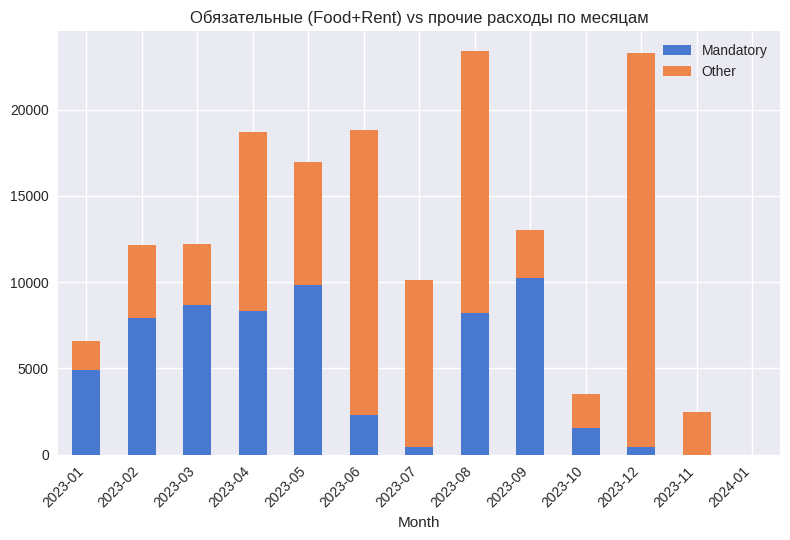

In [64]:
"""Гипотеза 66: для каждого месяца оценим 'обязательные' расходы (Rent + базовый Food) vs 'остальные'."""

food_month_total = (
    df_eda[df_eda["Category"] == "Food"]
    .groupby("Month")["Withdrawal"]
    .sum()
    .rename("FoodTotal")
)
rent_month_total = (
    df_eda[df_eda["Category"] == "Rent"]
    .groupby("Month")["Withdrawal"]
    .sum()
    .rename("RentTotal")
)
other_month_total = (
    df_eda[~df_eda["Category"].isin(["Food", "Rent"])]
    .groupby("Month")["Withdrawal"]
    .sum()
    .rename("OtherTotal")
)

mandatory_month = pd.concat([food_month_total, rent_month_total, other_month_total], axis=1).fillna(0)
mandatory_month["Mandatory"] = mandatory_month["FoodTotal"] + mandatory_month["RentTotal"]
mandatory_month["Other"] = mandatory_month["OtherTotal"]
mandatory_month["Month_str"] = mandatory_month.index.astype(str)

display(mandatory_month)

plt.figure(figsize=(10, 4))
mandatory_month[["Mandatory", "Other"]].plot(kind="bar", stacked=True)
plt.title("Обязательные (Food+Rent) vs прочие расходы по месяцам")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


,Withdrawal,Deposit,NetAmount
Direction,,,
Misc_Inflow,0.00,83701.09,83701.09
Misc_Outflow,92194.17,0.00,-92194.17


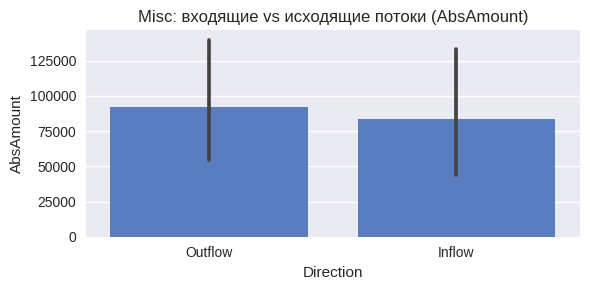

In [65]:
"""Гипотеза 67: разделим Misc на входящие и исходящие потоки, чтобы понять их природу."""

misc_eda = df_eda[df_eda["Category"] == "Misc"].copy()
misc_eda["Direction"] = np.where(misc_eda["Deposit"] > 0, "Inflow", "Outflow")

misc_summary = (
    misc_eda.groupby("Direction")[["Withdrawal", "Deposit", "NetAmount"]]
    .sum()
    .rename(index={"Inflow": "Misc_Inflow", "Outflow": "Misc_Outflow"})
)

display(misc_summary)

plt.figure(figsize=(6, 3))
sns.barplot(
    data=misc_eda,
    x="Direction",
    y="AbsAmount",
    estimator=sum,
)
plt.title("Misc: входящие vs исходящие потоки (AbsAmount)")
plt.tight_layout()
plt.show()


,Month,NetNoSalary,Month_str
0,2023-01,-5158.50,2023-01
1,2023-02,-10545.43,2023-02
2,2023-03,-11590.63,2023-03
3,2023-04,-11093.43,2023-04
4,2023-05,-11688.16,2023-05
5,2023-06,-5383.41,2023-06
6,2023-07,373.09,2023-07
7,2023-08,-7380.00,2023-08
8,2023-09,-12301.53,2023-09
9,2023-10,-1073.43,2023-10


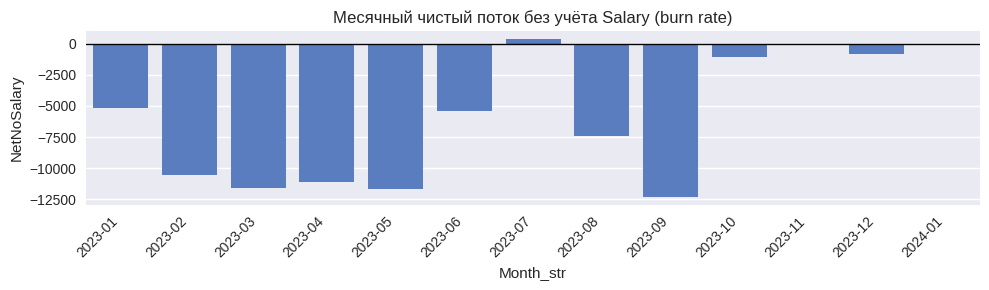

In [66]:
"""Гипотеза 68: оценим 'коэффициент сжигания' (burn rate) — средний месячный чистый отток без учёта зарплаты."""

# Уберём Salary из NetAmount, чтобы не 'маскировать' burn rate
no_salary = df_eda[df_eda["Category"] != "Salary"].copy()
burn_month = no_salary.groupby("Month")["NetAmount"].sum().rename("NetNoSalary").reset_index()
burn_month["Month_str"] = burn_month["Month"].astype(str)

display(burn_month)

plt.figure(figsize=(10, 3))
sns.barplot(data=burn_month, x="Month_str", y="NetNoSalary")
plt.axhline(0, color="black", linewidth=1)
plt.title("Месячный чистый поток без учёта Salary (burn rate)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


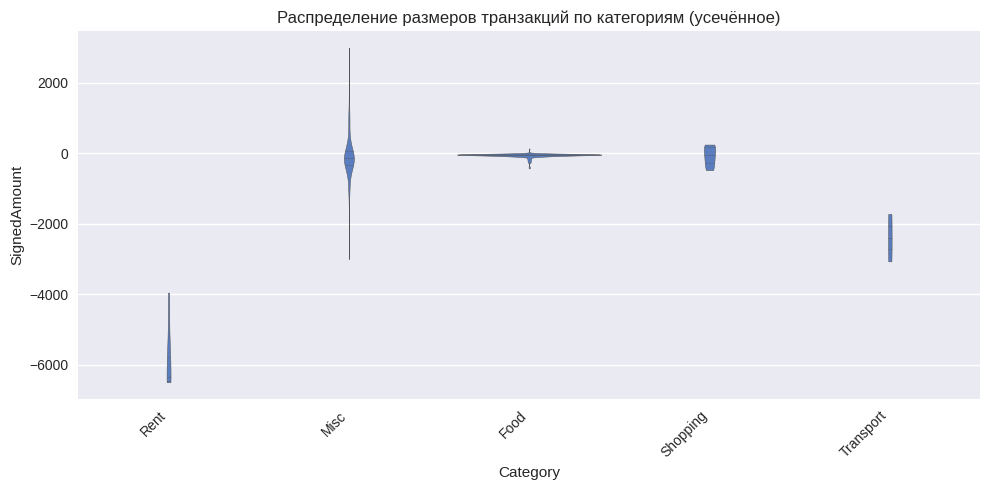

In [67]:
"""Гипотеза 69: распределение размеров транзакций по категориям (violinplot) показывает их 'профили'."""

sample_for_violin = df_eda.copy()
sample_for_violin["SignedAmount"] = np.where(
    sample_for_violin["Withdrawal"] > 0,
    -sample_for_violin["Withdrawal"],
    sample_for_violin["Deposit"],
)

# Ограничим экстремальные значения для наглядности
q_low, q_high = sample_for_violin["SignedAmount"].quantile([0.01, 0.99])
sample_for_violin_clip = sample_for_violin[
    (sample_for_violin["SignedAmount"] >= q_low)
    & (sample_for_violin["SignedAmount"] <= q_high)
].copy()

plt.figure(figsize=(10, 5))
sns.violinplot(
    data=sample_for_violin_clip,
    x="Category",
    y="SignedAmount",
    cut=0,
    inner="quartile",
)
plt.title("Распределение размеров транзакций по категориям (усечённое)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [68]:
"""Гипотеза 70: агрегируем ключевые инсайты в одну таблицу для дальнейшего использования в отчёте или презентации."""

insights = {}

insights["MonthsCount"] = int(df_eda["Month"].nunique())
insights["TotalIncome"] = float(df_eda["Deposit"].sum())
insights["TotalExpenses"] = float(df_eda["Withdrawal"].sum())
insights["MaxRentShare"] = float(share_eda["RentShare"].max()) if "share_eda" in globals() else None
insights["MinEndBalance"] = float(month_end_stats["Balance"].min())
insights["MaxEndBalance"] = float(month_end_stats["Balance"].max())
insights["StressDays"] = int(daily_bal["BelowCritical"].sum())

summary_insights = pd.Series(insights).to_frame("Value")
display(summary_insights)


,Value
MonthsCount,13.000000
TotalIncome,84561.850000
TotalExpenses,161236.570000
MaxRentShare,0.601355
MinEndBalance,0.150000
MaxEndBalance,3068.550000
StressDays,19.000000


In [69]:
"""Гипотеза 71: часть операций Misc/Transport — это переводы между своими счетами (парные вход/выход)."""

mt = df_eda[df_eda["Category"].isin(["Misc", "Transport"])].copy()

mt_in = mt[mt["Deposit"] > 0].copy()
mt_out = mt[mt["Withdrawal"] > 0].copy()

pairs = []
amount_tol = 1e-2

for _, row_in in mt_in.iterrows():
    amt = row_in["Deposit"]
    date_in = row_in["Date"]
    mask = (
        (mt_out["Date"] >= date_in - pd.Timedelta(days=1)) &
        (mt_out["Date"] <= date_in + pd.Timedelta(days=1)) &
        ((mt_out["Withdrawal"] - amt).abs() <= amount_tol)
    )
    candidates = mt_out[mask]
    for _, row_out in candidates.iterrows():
        pairs.append({
            "In_Date": date_in,
            "In_Category": row_in["Category"],
            "In_Deposit": row_in["Deposit"],
            "Out_Date": row_out["Date"],
            "Out_Category": row_out["Category"],
            "Out_Withdrawal": row_out["Withdrawal"],
            "Out_Ref": row_out["RefNo"],
        })

pairs_df = pd.DataFrame(pairs)

print("Возможные пары переводов между счетами (Misc/Transport):")
display(pairs_df.head(50))

print(f"Всего найдено пар: {len(pairs_df)}")


Возможные пары переводов между счетами (Misc/Transport):


,In_Date,In_Category,In_Deposit,Out_Date,Out_Category,Out_Withdrawal,Out_Ref
0,2023-02-03,Misc,500.0,2023-02-03,Misc,500.0,3.03E+11
1,2023-02-11,Misc,500.0,2023-02-12,Misc,500.0,3.04E+11
2,2023-04-03,Misc,1200.0,2023-04-02,Misc,1200.0,3.46E+11
3,2023-05-10,Misc,500.0,2023-05-10,Misc,500.0,3.50E+11
4,2023-06-09,Misc,8000.0,2023-06-09,Misc,8000.0,3.53E+11
5,2023-06-12,Misc,3000.0,2023-06-12,Misc,3000.0,3.16E+11
6,2023-07-08,Misc,7800.0,2023-07-08,Misc,7800.0,3.56E+11
7,2023-08-05,Misc,13000.0,2023-08-05,Misc,13000.0,3.22E+11
8,2023-11-01,Misc,500.0,2023-11-01,Misc,500.0,3.31E+11
9,2023-11-02,Misc,1000.0,2023-11-02,Misc,1000.0,3.67E+11


Всего найдено пар: 16


In [70]:
"""Гипотеза 72: Аномалии и их поиск"""
CRITICAL_BAL = 500
Z_THRESHOLD = 2.5
MISC_Q = 0.9

daily = df_eda.groupby("Date").agg(
    Withdrawal=("Withdrawal", "sum"),
    TxnCount=("Category", "count"),
    Balance=("Balance", "last"),
).reset_index()

mu, sigma = daily["Withdrawal"].mean(), daily["Withdrawal"].std(ddof=0) + 1e-9
daily["Z_withdraw"] = (daily["Withdrawal"] - mu) / sigma
daily["AboveZ"] = daily["Z_withdraw"].abs() > Z_THRESHOLD
daily["BelowCritical"] = daily["Balance"] < CRITICAL_BAL

misc_daily = (
    df_eda[df_eda["Category"] == "Misc"]
    .groupby("Date")["Withdrawal"]
    .sum()
    .rename("MiscSpend")
)
daily = daily.merge(misc_daily, on="Date", how="left")
daily["MiscSpend"] = daily["MiscSpend"].fillna(0)
daily["MiscShare"] = daily["MiscSpend"] / daily["Withdrawal"].replace(0, np.nan)

misc_eda = df_eda[df_eda["Category"] == "Misc"].copy()
big_misc_thr = misc_eda["Withdrawal"].quantile(MISC_Q)
big_misc = misc_eda[misc_eda["Withdrawal"] >= big_misc_thr]

print("Дни с аномальными расходами (|Z| >", Z_THRESHOLD, "):")
display(daily[daily["AboveZ"]])

print("\nДни с балансом ниже порога", CRITICAL_BAL, ":")
display(daily[daily["BelowCritical"]])

print("\nКрупные Misc (>= 90-й перцентиль): порог =", big_misc_thr)
display(big_misc[["Date", "Withdrawal", "Deposit", "Balance"]].sort_values("Withdrawal", ascending=False))

Дни с аномальными расходами (|Z| > 2.5 ):


,Date,Withdrawal,TxnCount,Balance,Z_withdraw,AboveZ,BelowCritical,MiscSpend,MiscShare
62,2023-06-09,8372.0,8,5016.55,2.770921,True,False,8262.0,0.986861
70,2023-07-08,7850.0,4,745.98,2.564454,True,False,7800.0,0.993631
76,2023-08-02,9001.0,10,239.62,3.019709,True,True,1388.0,0.154205
79,2023-08-05,13000.0,2,44.62,4.601434,True,True,13000.0,1.000000
82,2023-09-01,7989.0,7,4876.86,2.619433,True,False,557.0,0.069721
113,2023-12-09,15048.0,1,243.97,5.411479,True,True,15048.0,1.000000



Дни с балансом ниже порога 500 :


,Date,Withdrawal,TxnCount,Balance,Z_withdraw,AboveZ,BelowCritical,MiscSpend,MiscShare
29,2023-03-12,464.00,5,306.26,-0.356931,False,True,300.0,0.646552
76,2023-08-02,9001.00,10,239.62,3.019709,True,True,1388.0,0.154205
77,2023-08-03,175.00,4,64.62,-0.471239,False,True,0.0,0.000000
78,2023-08-04,20.00,1,44.62,-0.532546,False,True,0.0,0.000000
79,2023-08-05,13000.00,2,44.62,4.601434,True,True,13000.0,1.000000
81,2023-08-12,489.00,3,141.62,-0.347043,False,True,393.0,0.803681
92,2023-09-11,492.24,7,240.33,-0.345761,False,True,125.0,0.253941
93,2023-09-12,195.00,5,45.33,-0.463329,False,True,0.0,0.000000
96,2023-10-03,1445.74,10,285.58,0.031377,False,True,1180.0,0.816191
98,2023-10-05,180.00,3,478.58,-0.469261,False,True,0.0,0.000000



Крупные Misc (>= 90-й перцентиль): порог = 690.0


,Date,Withdrawal,Deposit,Balance
553,2023-12-09,15048.00,0.0,243.97
429,2023-08-05,13000.00,0.0,44.62
360,2023-06-09,8000.00,0.0,5016.55
394,2023-07-08,7800.00,0.0,745.98
208,2023-04-10,3000.00,0.0,1395.51
378,2023-06-12,3000.00,0.0,3233.55
182,2023-04-05,2000.00,0.0,1742.79
232,2023-05-02,1391.16,0.0,4094.01
168,2023-04-02,1200.00,0.0,4445.79
398,2023-07-10,1100.00,0.0,1861.98


In [71]:
summary_lines = []

anoms = daily[daily["AboveZ"]]
if not anoms.empty:
    summary_lines.append(f"Аномальные дни по расходам: {len(anoms)}, макс Z = {anoms['Z_withdraw'].abs().max():.2f}")
else:
    summary_lines.append("Аномальные дни по расходам не найдены по Z-score.")

lowb = daily[daily["BelowCritical"]]
summary_lines.append(f"Дней с балансом ниже {CRITICAL_BAL}: {len(lowb)}")

high_misc_share = daily[daily["MiscShare"].fillna(0) > 0.5]
summary_lines.append(f"Дней с долей Misc > 50% от расходов: {len(high_misc_share)}")

summary_lines.append(f"Крупных Misc (>=90 перцентиль): {len(big_misc)}")

print("\n".join(summary_lines))

Аномальные дни по расходам: 6, макс Z = 5.41
Дней с балансом ниже 500: 19
Дней с долей Misc > 50% от расходов: 60
Крупных Misc (>=90 перцентиль): 20
